<a href="https://colab.research.google.com/github/JohnSmith69969/ADS2002-Monash-Solar-Group/blob/Callum/ADS2002%20Monash%20Solar%20Callumipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [157]:
Phase_2 = convert_tsf_to_dataframe("phase_2_data.tsf")
Phase_2

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [158]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = Phase_2

In [159]:
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [160]:
dataset = loaded_data.explode('series_value')
dataset

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,13.47
11,Solar5,2019-01-15 13:00:00,15.93
11,Solar5,2019-01-15 13:00:00,17.11
11,Solar5,2019-01-15 13:00:00,18.29


## Solar 0

In [161]:
solar_0 = dataset.loc[dataset['series_name']=='Solar0']
solar_0

,series_name,start_timestamp,series_value
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
...,...,...,...
6,Solar0,2020-04-25 14:00:00,18.53
6,Solar0,2020-04-25 14:00:00,22.23
6,Solar0,2020-04-25 14:00:00,23.39
6,Solar0,2020-04-25 14:00:00,24.56


In [162]:
import datetime

# Input start date
start_date_str = '25/04/2020 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][6])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [163]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_0['start_timestamp']=datetime_column

<ipython-input-163-362cacee587e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_0['start_timestamp']=datetime_column


In [164]:
solar_0 = solar_0.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [165]:
solar_0 = solar_0[solar_0.power_output != "NaN"]

In [166]:
solar_0["power_output"] = pd.to_numeric(solar_0["power_output"])
solar_0

,solar_no,timestamp,power_output
6,Solar0,2020-04-25 14:00:00,0.00
6,Solar0,2020-04-25 14:15:00,0.00
6,Solar0,2020-04-25 14:30:00,0.00
6,Solar0,2020-04-25 14:45:00,0.00
6,Solar0,2020-04-25 15:00:00,0.00
...,...,...,...
6,Solar0,2020-10-31 22:45:00,18.53
6,Solar0,2020-10-31 23:00:00,22.23
6,Solar0,2020-10-31 23:15:00,23.39
6,Solar0,2020-10-31 23:30:00,24.56


## Solar 1

In [167]:
solar_1 = dataset.loc[dataset['series_name']=='Solar1']
solar_1

,series_name,start_timestamp,series_value
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
...,...,...,...
7,Solar1,2018-12-31 13:00:00,4.96
7,Solar1,2018-12-31 13:00:00,5.88
7,Solar1,2018-12-31 13:00:00,6.31
7,Solar1,2018-12-31 13:00:00,6.73


In [168]:
import datetime

# Input start date
start_date_str = '31/12/2018 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][7])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [169]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_1['start_timestamp']=datetime_column

<ipython-input-169-6ca112a44dc9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_1['start_timestamp']=datetime_column


In [170]:
solar_1 = solar_1.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [171]:
solar_1 = solar_1[solar_1.power_output != "NaN"]

In [172]:
solar_1["power_output"] = pd.to_numeric(solar_1["power_output"])
solar_1

,solar_no,timestamp,power_output
7,Solar1,2018-12-31 13:00:00,0.00
7,Solar1,2018-12-31 13:15:00,0.00
7,Solar1,2018-12-31 13:30:00,0.00
7,Solar1,2018-12-31 13:45:00,0.00
7,Solar1,2018-12-31 14:00:00,0.00
...,...,...,...
7,Solar1,2020-10-31 22:45:00,4.96
7,Solar1,2020-10-31 23:00:00,5.88
7,Solar1,2020-10-31 23:15:00,6.31
7,Solar1,2020-10-31 23:30:00,6.73


## Solar 2

In [173]:
solar_2 = dataset.loc[dataset['series_name']=='Solar2']
solar_2

,series_name,start_timestamp,series_value
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
...,...,...,...
8,Solar2,2019-06-05 14:00:00,4.73
8,Solar2,2019-06-05 14:00:00,5.64
8,Solar2,2019-06-05 14:00:00,5.99
8,Solar2,2019-06-05 14:00:00,6.35


In [174]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][8])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [175]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_2['start_timestamp']=datetime_column

<ipython-input-175-725571f5cdf1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_2['start_timestamp']=datetime_column


In [176]:
solar_2 = solar_2.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [177]:
solar_2 = solar_2[solar_2.power_output != "NaN"]

In [178]:
solar_2["power_output"] = pd.to_numeric(solar_2["power_output"])
solar_2

,solar_no,timestamp,power_output
8,Solar2,2019-06-05 14:00:00,0.00
8,Solar2,2019-06-05 14:15:00,0.00
8,Solar2,2019-06-05 14:30:00,0.00
8,Solar2,2019-06-05 14:45:00,0.00
8,Solar2,2019-06-05 15:00:00,0.00
...,...,...,...
8,Solar2,2020-10-31 22:45:00,4.73
8,Solar2,2020-10-31 23:00:00,5.64
8,Solar2,2020-10-31 23:15:00,5.99
8,Solar2,2020-10-31 23:30:00,6.35


## Solar 3

In [179]:
solar_3 = dataset.loc[dataset['series_name']=='Solar3']
solar_3

,series_name,start_timestamp,series_value
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
...,...,...,...
9,Solar3,2019-06-05 14:00:00,4.31
9,Solar3,2019-06-05 14:00:00,5.08
9,Solar3,2019-06-05 14:00:00,5.45
9,Solar3,2019-06-05 14:00:00,5.83


In [180]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][9])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [181]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_3['start_timestamp']=datetime_column

<ipython-input-181-b16580250973>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_3['start_timestamp']=datetime_column


In [182]:
solar_3 = solar_3.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [183]:
solar_3 = solar_3[solar_3.power_output != "NaN"]

In [184]:
solar_3["power_output"] = pd.to_numeric(solar_3["power_output"])
solar_3

,solar_no,timestamp,power_output
9,Solar3,2019-06-05 14:00:00,0.00
9,Solar3,2019-06-05 14:15:00,0.00
9,Solar3,2019-06-05 14:30:00,0.00
9,Solar3,2019-06-05 14:45:00,0.00
9,Solar3,2019-06-05 15:00:00,0.00
...,...,...,...
9,Solar3,2020-10-31 22:45:00,4.31
9,Solar3,2020-10-31 23:00:00,5.08
9,Solar3,2020-10-31 23:15:00,5.45
9,Solar3,2020-10-31 23:30:00,5.83


## Solar 4

In [185]:
solar_4 = dataset.loc[dataset['series_name']=='Solar4']
solar_4

,series_name,start_timestamp,series_value
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
...,...,...,...
10,Solar4,2019-06-05 14:00:00,2.84
10,Solar4,2019-06-05 14:00:00,3.4
10,Solar4,2019-06-05 14:00:00,3.62
10,Solar4,2019-06-05 14:00:00,3.85


In [186]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][10])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [187]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_4['start_timestamp']=datetime_column

<ipython-input-187-620bd6fbefb0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_4['start_timestamp']=datetime_column


In [188]:
solar_4 = solar_4.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [189]:
solar_4 = solar_4[solar_4.power_output != "NaN"]

In [190]:
solar_4["power_output"] = pd.to_numeric(solar_4["power_output"])
solar_4

,solar_no,timestamp,power_output
10,Solar4,2019-06-05 14:00:00,0.00
10,Solar4,2019-06-05 14:15:00,0.00
10,Solar4,2019-06-05 14:30:00,0.00
10,Solar4,2019-06-05 14:45:00,0.00
10,Solar4,2019-06-05 15:00:00,0.00
...,...,...,...
10,Solar4,2020-10-31 22:45:00,2.84
10,Solar4,2020-10-31 23:00:00,3.40
10,Solar4,2020-10-31 23:15:00,3.62
10,Solar4,2020-10-31 23:30:00,3.85


## Solar 5

In [191]:
solar_5 = dataset.loc[dataset['series_name']=='Solar5']
solar_5

,series_name,start_timestamp,series_value
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,13.47
11,Solar5,2019-01-15 13:00:00,15.93
11,Solar5,2019-01-15 13:00:00,17.11
11,Solar5,2019-01-15 13:00:00,18.29


In [192]:
import datetime

# Input start date
start_date_str = '15/01/2019 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][11])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))

End Date: 31/10/2020 23:45:00


In [193]:
end_date_str = '31/10/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_5['start_timestamp']=datetime_column

<ipython-input-193-7932098d74ed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_5['start_timestamp']=datetime_column


In [194]:
solar_5 = solar_5.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})

In [195]:
solar_5 = solar_5[solar_5.power_output != "NaN"]

In [196]:
solar_5["power_output"] = pd.to_numeric(solar_5["power_output"])
solar_5

,solar_no,timestamp,power_output
11,Solar5,2019-01-15 13:00:00,0.00
11,Solar5,2019-01-15 13:15:00,0.00
11,Solar5,2019-01-15 13:30:00,0.00
11,Solar5,2019-01-15 13:45:00,0.00
11,Solar5,2019-01-15 14:00:00,0.00
...,...,...,...
11,Solar5,2020-10-31 22:45:00,13.47
11,Solar5,2020-10-31 23:00:00,15.93
11,Solar5,2020-10-31 23:15:00,17.11
11,Solar5,2020-10-31 23:30:00,18.29


## Combining Weather data with our solar dataset

### Indexing timestamp

In [197]:
solar_0['timestamp'] = solar_0['timestamp'] + pd.Timedelta(hours=10)
solar_1['timestamp'] = solar_1['timestamp'] + pd.Timedelta(hours=10)
solar_2['timestamp'] = solar_2['timestamp'] + pd.Timedelta(hours=10)
solar_3['timestamp'] = solar_3['timestamp'] + pd.Timedelta(hours=10)
solar_4['timestamp'] = solar_4['timestamp'] + pd.Timedelta(hours=10)
solar_5['timestamp'] = solar_5['timestamp'] + pd.Timedelta(hours=10)

In [198]:
solar_0 = solar_0.set_index(pd.DatetimeIndex(solar_0['timestamp'])).drop(solar_0.columns[1], axis=1)
solar_0

,solar_no,power_output
timestamp,,
2020-04-26 00:00:00,Solar0,0.00
2020-04-26 00:15:00,Solar0,0.00
2020-04-26 00:30:00,Solar0,0.00
2020-04-26 00:45:00,Solar0,0.00
2020-04-26 01:00:00,Solar0,0.00
...,...,...
2020-11-01 08:45:00,Solar0,18.53
2020-11-01 09:00:00,Solar0,22.23
2020-11-01 09:15:00,Solar0,23.39


In [199]:
solar_1 = solar_1.set_index(pd.DatetimeIndex(solar_1['timestamp'])).drop(solar_1.columns[1], axis=1)
solar_1

,solar_no,power_output
timestamp,,
2018-12-31 23:00:00,Solar1,0.00
2018-12-31 23:15:00,Solar1,0.00
2018-12-31 23:30:00,Solar1,0.00
2018-12-31 23:45:00,Solar1,0.00
2019-01-01 00:00:00,Solar1,0.00
...,...,...
2020-11-01 08:45:00,Solar1,4.96
2020-11-01 09:00:00,Solar1,5.88
2020-11-01 09:15:00,Solar1,6.31


In [200]:
solar_2 = solar_2.set_index(pd.DatetimeIndex(solar_2['timestamp'])).drop(solar_2.columns[1], axis=1)
solar_2

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar2,0.00
2019-06-06 00:15:00,Solar2,0.00
2019-06-06 00:30:00,Solar2,0.00
2019-06-06 00:45:00,Solar2,0.00
2019-06-06 01:00:00,Solar2,0.00
...,...,...
2020-11-01 08:45:00,Solar2,4.73
2020-11-01 09:00:00,Solar2,5.64
2020-11-01 09:15:00,Solar2,5.99


In [201]:
solar_3 = solar_3.set_index(pd.DatetimeIndex(solar_3['timestamp'])).drop(solar_3.columns[1], axis=1)
solar_3

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar3,0.00
2019-06-06 00:15:00,Solar3,0.00
2019-06-06 00:30:00,Solar3,0.00
2019-06-06 00:45:00,Solar3,0.00
2019-06-06 01:00:00,Solar3,0.00
...,...,...
2020-11-01 08:45:00,Solar3,4.31
2020-11-01 09:00:00,Solar3,5.08
2020-11-01 09:15:00,Solar3,5.45


In [202]:
solar_4 = solar_4.set_index(pd.DatetimeIndex(solar_4['timestamp'])).drop(solar_4.columns[1], axis=1)
solar_4

,solar_no,power_output
timestamp,,
2019-06-06 00:00:00,Solar4,0.00
2019-06-06 00:15:00,Solar4,0.00
2019-06-06 00:30:00,Solar4,0.00
2019-06-06 00:45:00,Solar4,0.00
2019-06-06 01:00:00,Solar4,0.00
...,...,...
2020-11-01 08:45:00,Solar4,2.84
2020-11-01 09:00:00,Solar4,3.40
2020-11-01 09:15:00,Solar4,3.62


In [203]:
solar_5 = solar_5.set_index(pd.DatetimeIndex(solar_5['timestamp'])).drop(solar_5.columns[1], axis=1)
solar_5

,solar_no,power_output
timestamp,,
2019-01-15 23:00:00,Solar5,0.00
2019-01-15 23:15:00,Solar5,0.00
2019-01-15 23:30:00,Solar5,0.00
2019-01-15 23:45:00,Solar5,0.00
2019-01-16 00:00:00,Solar5,0.00
...,...,...
2020-11-01 08:45:00,Solar5,13.47
2020-11-01 09:00:00,Solar5,15.93
2020-11-01 09:15:00,Solar5,17.11


### Combining stuff

In [204]:
weather = pd.read_csv("monash_weather.csv")
weather

,Unnamed: 0,datetime (UTC),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,0,2010-01-01 10:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,1,2010-01-01 11:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2,2010-01-01 12:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,3,2010-01-01 13:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,4,2010-01-01 14:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...
100052,100052,2021-06-01 06:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,100053,2021-06-01 07:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,100054,2021-06-01 08:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,100055,2021-06-01 09:00:00,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [205]:
weather['datetime (UTC)'] = pd.to_datetime(weather['datetime (UTC)'])

weather['datetime (UTC)'] = weather['datetime (UTC)'] + pd.Timedelta(hours=10)
weather

,Unnamed: 0,datetime (UTC),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,0,2010-01-01 20:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,1,2010-01-01 21:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2,2010-01-01 22:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,3,2010-01-01 23:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,4,2010-01-02 00:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...
100052,100052,2021-06-01 16:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,100053,2021-06-01 17:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,100054,2021-06-01 18:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,100055,2021-06-01 19:00:00,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [206]:
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather

,datetime (UTC),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,
2010-01-01 20:00:00,2010-01-01 20:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
2010-01-01 21:00:00,2010-01-01 21:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2010-01-01 22:00:00,2010-01-01 22:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
2010-01-01 23:00:00,2010-01-01 23:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
2010-01-02 00:00:00,2010-01-02 00:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...
2021-06-01 16:00:00,2021-06-01 16:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
2021-06-01 17:00:00,2021-06-01 17:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
2021-06-01 18:00:00,2021-06-01 18:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00


In [207]:
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather

<ipython-input-207-6fc315b3b116>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals


,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,
2010-01-01 20:00:00,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 20:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 20:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 20:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 21:00:00,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 19:00:00,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-06-01 19:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 19:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
weather.isna().sum()

temperature (degC)                   300168
dewpoint_temperature (degC)          300168
wind_speed (m/s)                     300168
mean_sea_level_pressure (Pa)         300168
relative_humidity ((0-1))            300168
surface_solar_radiation (W/m^2)      300168
surface_thermal_radiation (W/m^2)    300168
total_cloud_cover (0-1)              300168
dtype: int64

In [209]:
weather = weather.interpolate(method='linear') #Input NaN
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,
2010-01-01 20:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 20:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 20:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 20:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 21:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 19:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 19:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 19:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [210]:
weather.isna().sum()

temperature (degC)                   0
dewpoint_temperature (degC)          0
wind_speed (m/s)                     0
mean_sea_level_pressure (Pa)         0
relative_humidity ((0-1))            0
surface_solar_radiation (W/m^2)      0
surface_thermal_radiation (W/m^2)    0
total_cloud_cover (0-1)              0
dtype: int64

In [211]:
weather.index.names = ['timestamp']
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2010-01-01 20:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 20:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 20:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 20:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 21:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 19:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 19:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 19:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [212]:
solar0 = pd.merge(solar_0, weather, left_index=True, right_index=True)
solar0

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2020-04-26 00:00:00,Solar0,0.00,20.100,11.400,6.600,101557.400,0.6,482.0,333.100,0.200
2020-04-26 00:15:00,Solar0,0.00,20.175,11.375,6.500,101539.050,0.6,456.9,335.000,0.400
2020-04-26 00:30:00,Solar0,0.00,20.250,11.350,6.400,101520.700,0.6,431.8,336.900,0.600
2020-04-26 00:45:00,Solar0,0.00,20.325,11.325,6.300,101502.350,0.6,406.7,338.800,0.800
2020-04-26 01:00:00,Solar0,0.00,20.400,11.300,6.200,101484.000,0.6,381.6,340.700,1.000
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar0,18.53,12.050,9.375,4.275,101948.875,0.8,0.0,336.375,1.000
2020-11-01 09:00:00,Solar0,22.23,12.000,9.300,4.200,101948.000,0.8,0.0,332.000,1.000
2020-11-01 09:15:00,Solar0,23.39,11.950,9.250,4.175,101959.000,0.8,0.0,330.850,0.975


In [213]:
solar1 = pd.merge(solar_1, weather, left_index=True, right_index=True)
solar1

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2018-12-31 23:00:00,Solar1,0.00,23.600,14.600,2.900,101099.300,0.6,1017.200,369.200,0.200
2018-12-31 23:15:00,Solar1,0.00,23.575,14.600,3.075,101075.525,0.6,1003.925,368.900,0.200
2018-12-31 23:30:00,Solar1,0.00,23.550,14.600,3.250,101051.750,0.6,990.650,368.600,0.200
2018-12-31 23:45:00,Solar1,0.00,23.525,14.600,3.425,101027.975,0.6,977.375,368.300,0.200
2019-01-01 00:00:00,Solar1,0.00,23.500,14.600,3.600,101004.200,0.6,964.100,368.000,0.200
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar1,4.96,12.050,9.375,4.275,101948.875,0.8,0.000,336.375,1.000
2020-11-01 09:00:00,Solar1,5.88,12.000,9.300,4.200,101948.000,0.8,0.000,332.000,1.000
2020-11-01 09:15:00,Solar1,6.31,11.950,9.250,4.175,101959.000,0.8,0.000,330.850,0.975


In [214]:
solar2 = pd.merge(solar_2, weather, left_index=True, right_index=True)
solar2

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-06-06 00:00:00,Solar2,0.00,12.00,6.000,5.300,103090.000,0.7,241.700,321.800,0.800
2019-06-06 00:15:00,Solar2,0.00,11.95,6.000,5.175,103099.775,0.7,213.325,324.575,0.800
2019-06-06 00:30:00,Solar2,0.00,11.90,6.000,5.050,103109.550,0.7,184.950,327.350,0.800
2019-06-06 00:45:00,Solar2,0.00,11.85,6.000,4.925,103119.325,0.7,156.575,330.125,0.800
2019-06-06 01:00:00,Solar2,0.00,11.80,6.000,4.800,103129.100,0.7,128.200,332.900,0.800
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar2,4.73,12.05,9.375,4.275,101948.875,0.8,0.000,336.375,1.000
2020-11-01 09:00:00,Solar2,5.64,12.00,9.300,4.200,101948.000,0.8,0.000,332.000,1.000
2020-11-01 09:15:00,Solar2,5.99,11.95,9.250,4.175,101959.000,0.8,0.000,330.850,0.975


In [215]:
solar3 = pd.merge(solar_3, weather, left_index=True, right_index=True)
solar3

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-06-06 00:00:00,Solar3,0.00,12.00,6.000,5.300,103090.000,0.7,241.700,321.800,0.800
2019-06-06 00:15:00,Solar3,0.00,11.95,6.000,5.175,103099.775,0.7,213.325,324.575,0.800
2019-06-06 00:30:00,Solar3,0.00,11.90,6.000,5.050,103109.550,0.7,184.950,327.350,0.800
2019-06-06 00:45:00,Solar3,0.00,11.85,6.000,4.925,103119.325,0.7,156.575,330.125,0.800
2019-06-06 01:00:00,Solar3,0.00,11.80,6.000,4.800,103129.100,0.7,128.200,332.900,0.800
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar3,4.31,12.05,9.375,4.275,101948.875,0.8,0.000,336.375,1.000
2020-11-01 09:00:00,Solar3,5.08,12.00,9.300,4.200,101948.000,0.8,0.000,332.000,1.000
2020-11-01 09:15:00,Solar3,5.45,11.95,9.250,4.175,101959.000,0.8,0.000,330.850,0.975


In [216]:
solar4 = pd.merge(solar_4, weather, left_index=True, right_index=True)
solar4

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-06-06 00:00:00,Solar4,0.00,12.00,6.000,5.300,103090.000,0.7,241.700,321.800,0.800
2019-06-06 00:15:00,Solar4,0.00,11.95,6.000,5.175,103099.775,0.7,213.325,324.575,0.800
2019-06-06 00:30:00,Solar4,0.00,11.90,6.000,5.050,103109.550,0.7,184.950,327.350,0.800
2019-06-06 00:45:00,Solar4,0.00,11.85,6.000,4.925,103119.325,0.7,156.575,330.125,0.800
2019-06-06 01:00:00,Solar4,0.00,11.80,6.000,4.800,103129.100,0.7,128.200,332.900,0.800
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar4,2.84,12.05,9.375,4.275,101948.875,0.8,0.000,336.375,1.000
2020-11-01 09:00:00,Solar4,3.40,12.00,9.300,4.200,101948.000,0.8,0.000,332.000,1.000
2020-11-01 09:15:00,Solar4,3.62,11.95,9.250,4.175,101959.000,0.8,0.000,330.850,0.975


In [217]:
solar5 = pd.merge(solar_5, weather, left_index=True, right_index=True)
solar5

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-01-15 23:00:00,Solar5,0.00,32.100,16.200,4.200,100782.400,0.4,847.300,399.700,1.000
2019-01-15 23:15:00,Solar5,0.00,32.025,16.075,4.400,100793.525,0.4,839.975,401.675,0.950
2019-01-15 23:30:00,Solar5,0.00,31.950,15.950,4.600,100804.650,0.4,832.650,403.650,0.900
2019-01-15 23:45:00,Solar5,0.00,31.875,15.825,4.800,100815.775,0.4,825.325,405.625,0.850
2019-01-16 00:00:00,Solar5,0.00,31.800,15.700,5.000,100826.900,0.4,818.000,407.600,0.800
...,...,...,...,...,...,...,...,...,...,...
2020-11-01 08:45:00,Solar5,13.47,12.050,9.375,4.275,101948.875,0.8,0.000,336.375,1.000
2020-11-01 09:00:00,Solar5,15.93,12.000,9.300,4.200,101948.000,0.8,0.000,332.000,1.000
2020-11-01 09:15:00,Solar5,17.11,11.950,9.250,4.175,101959.000,0.8,0.000,330.850,0.975


## Data analysis

In [218]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(solar):
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(solar.corr(), vmin=-1, vmax=1, annot=True,cmap="Reds")
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

<ipython-input-218-ed4129397c9c>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(solar.corr(), vmin=-1, vmax=1, annot=True,cmap="Reds")


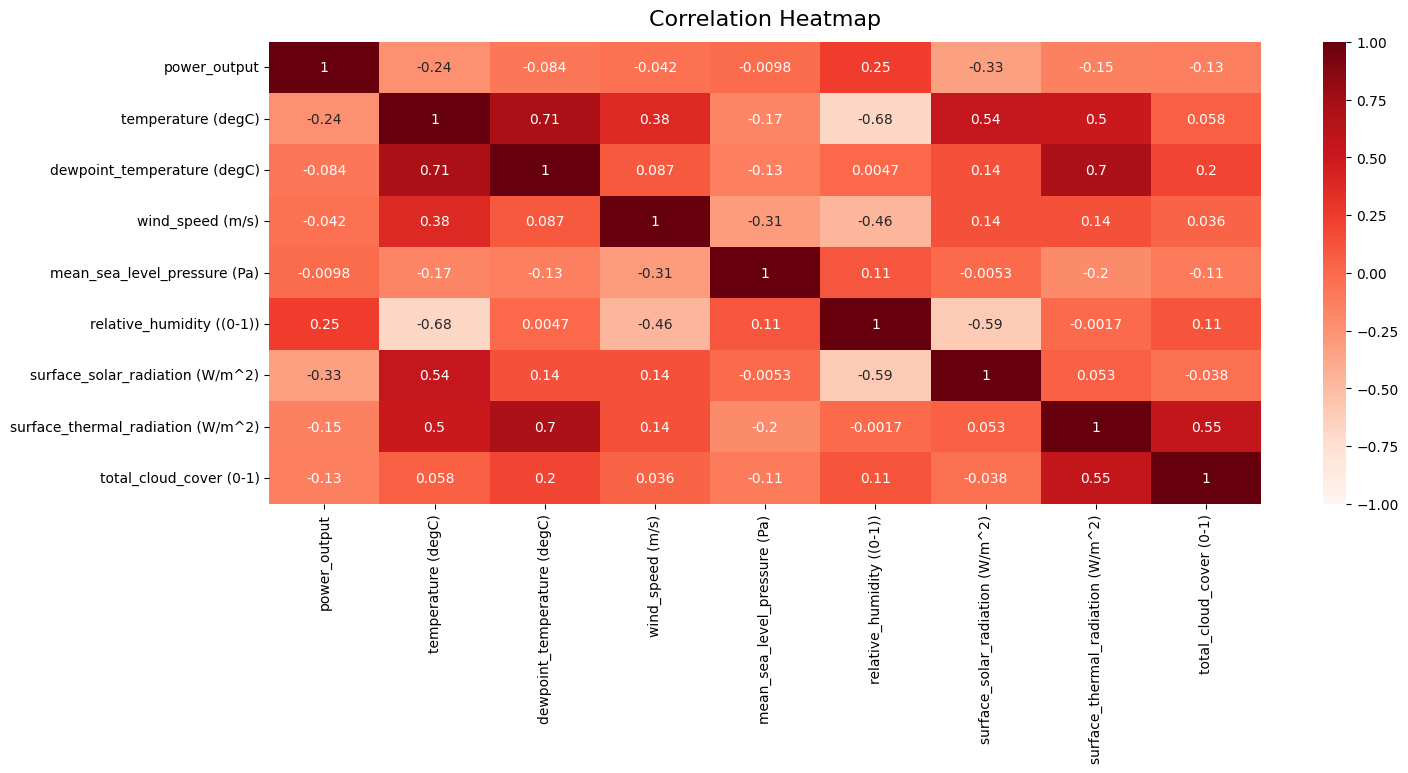

In [219]:
heatmap(solar0)

<ipython-input-218-ed4129397c9c>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(solar.corr(), vmin=-1, vmax=1, annot=True,cmap="Reds")


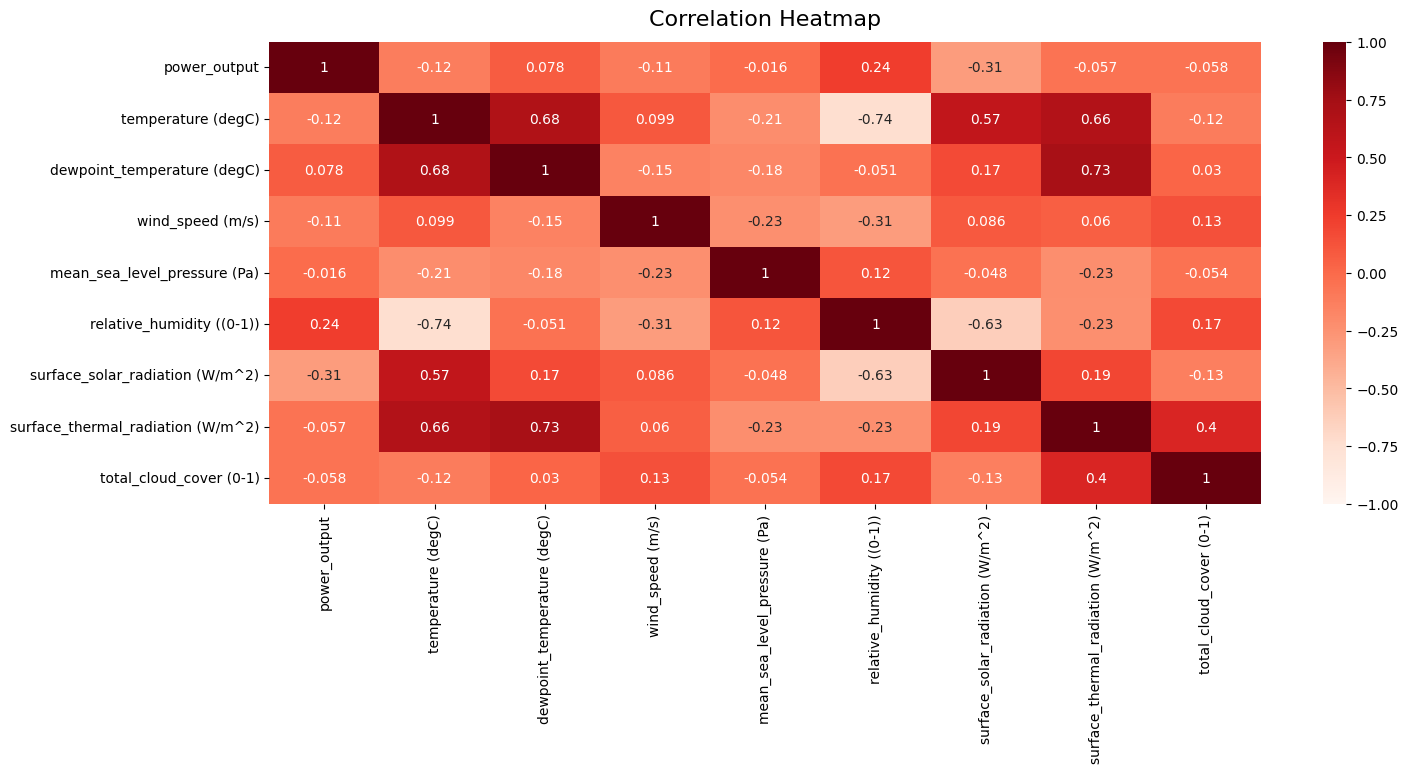

In [220]:
heatmap(solar1)

<ipython-input-218-ed4129397c9c>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(solar.corr(), vmin=-1, vmax=1, annot=True,cmap="Reds")


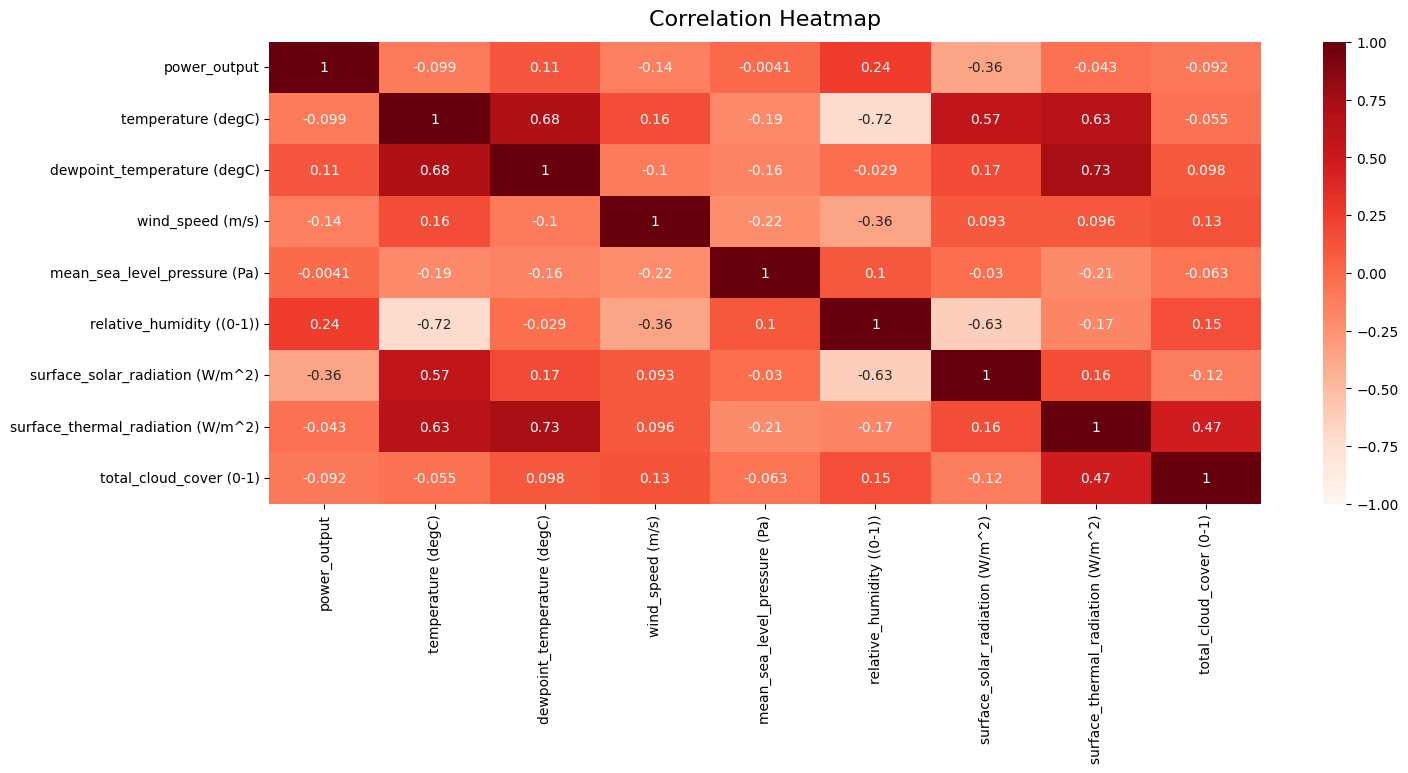

In [221]:
heatmap(solar2)

- So basically there are 3 most important variables notwithstanding the solar panel, such as Relative humidity, surface_solar_radiation and Temperature

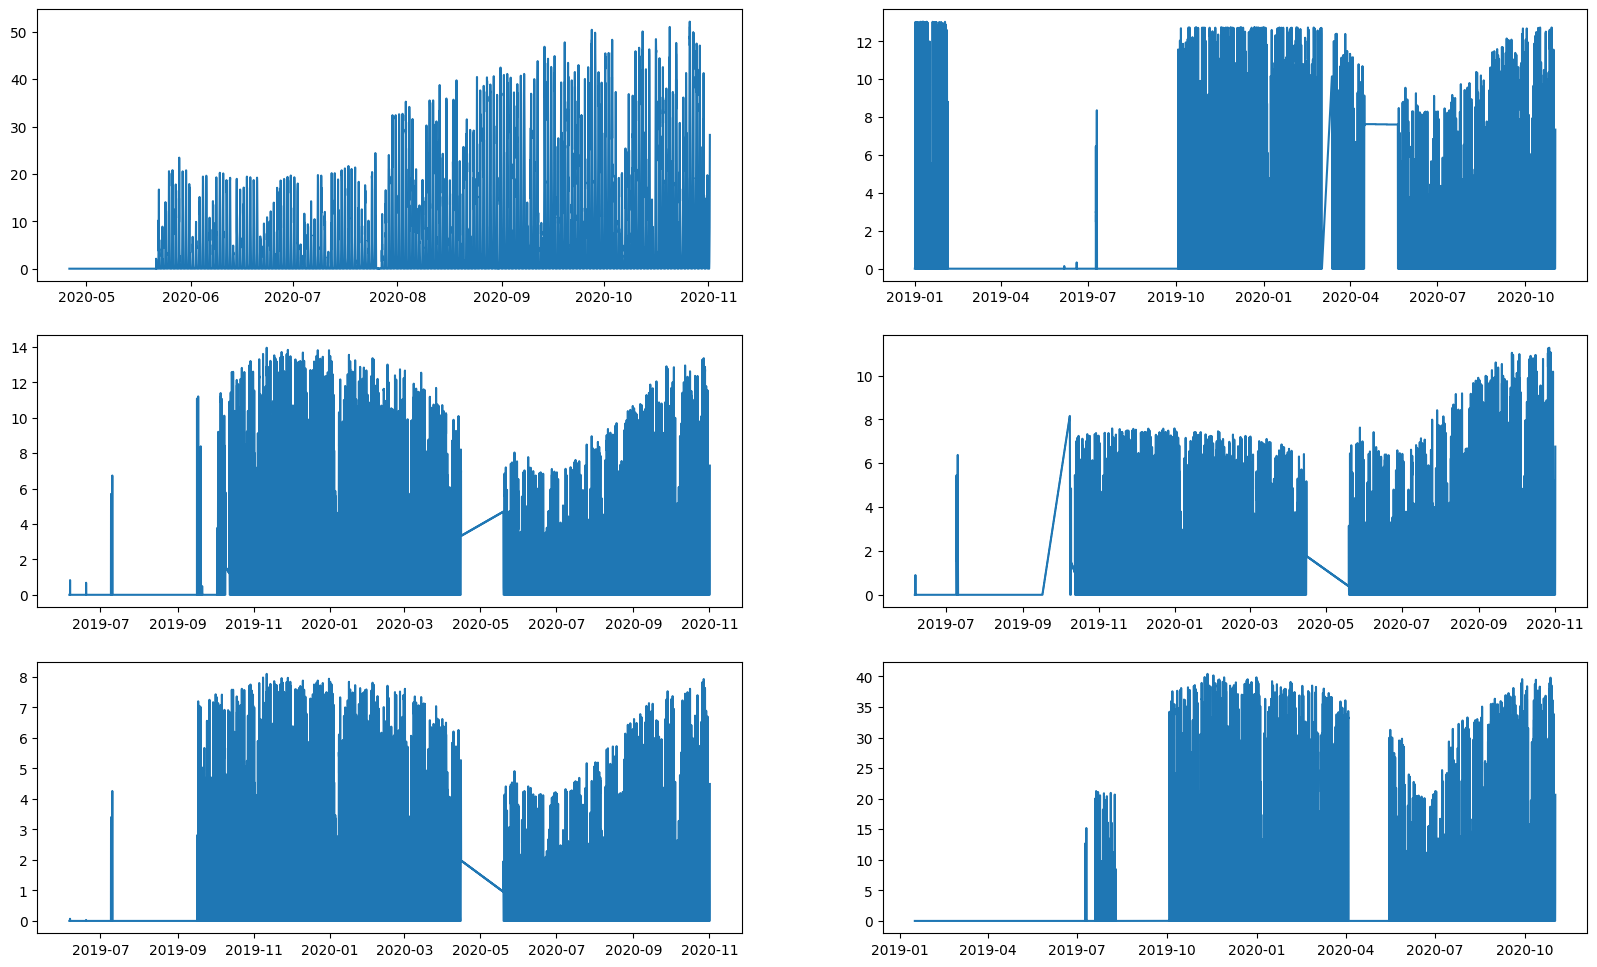

In [222]:
fig, ax = plt.subplots(3, 2,figsize=(20, 12))

ax[0, 0].plot(solar0.index,solar0['power_output'])
ax[0, 1].plot(solar1.index,solar1['power_output'])
ax[1, 0].plot(solar2.index,solar2['power_output'])
ax[1, 1].plot(solar3.index,solar3['power_output'])
ax[2, 0].plot(solar4.index,solar4['power_output'])
ax[2, 1].plot(solar5.index,solar5['power_output'])

plt.show()

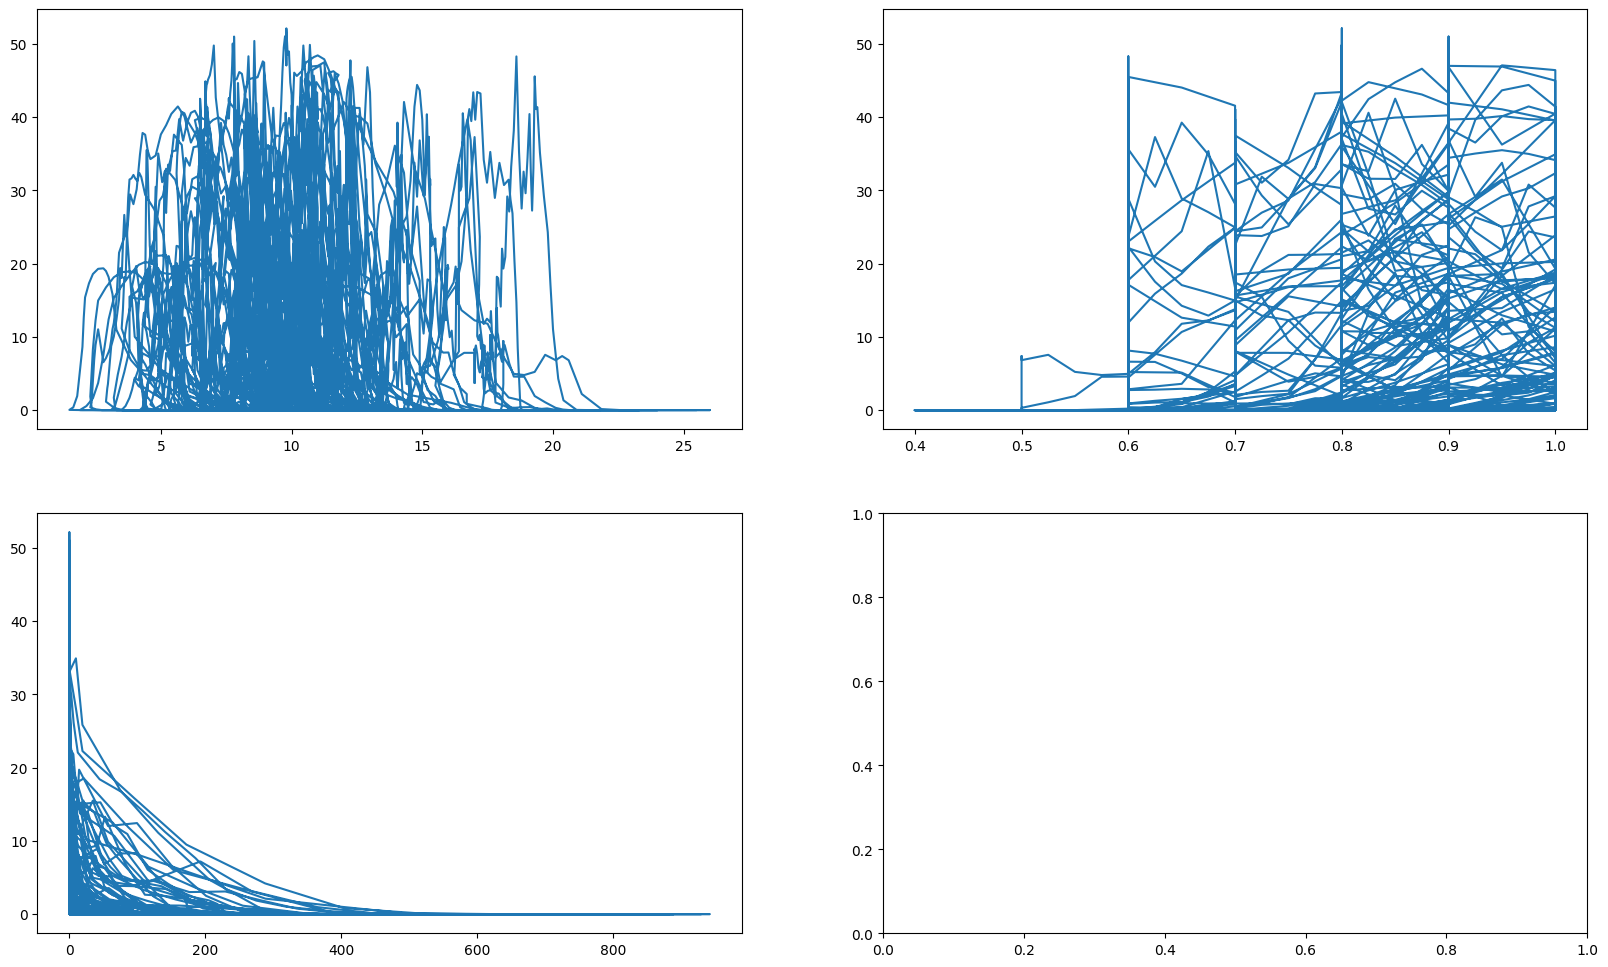

In [223]:
fig, ax = plt.subplots(2, 2,figsize=(20, 12))

ax[0,0].plot(solar0['temperature (degC)'],solar0['power_output'])
ax[0,1].plot(solar0['relative_humidity ((0-1))'],solar0['power_output'])
ax[1,0].plot(solar0['surface_solar_radiation (W/m^2)'],solar0['power_output'])


In [224]:
solar0[solar0['power_output']==0]

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2020-04-26 00:00:00,Solar0,0.0,20.100,11.400,6.600,101557.400,0.6,482.0,333.10,0.2
2020-04-26 00:15:00,Solar0,0.0,20.175,11.375,6.500,101539.050,0.6,456.9,335.00,0.4
2020-04-26 00:30:00,Solar0,0.0,20.250,11.350,6.400,101520.700,0.6,431.8,336.90,0.6
2020-04-26 00:45:00,Solar0,0.0,20.325,11.325,6.300,101502.350,0.6,406.7,338.80,0.8
2020-04-26 01:00:00,Solar0,0.0,20.400,11.300,6.200,101484.000,0.6,381.6,340.70,1.0
...,...,...,...,...,...,...,...,...,...,...
2020-05-21 14:00:00,Solar0,0.0,9.300,7.800,1.800,101344.000,0.9,0.0,346.00,1.0
2020-05-21 14:15:00,Solar0,0.0,9.350,7.850,1.725,101360.275,0.9,0.0,347.05,1.0
2020-05-21 14:30:00,Solar0,0.0,9.400,7.900,1.650,101376.550,0.9,0.0,348.10,1.0


In [225]:
solar1[pd.Timestamp("2019-01-03 12:00:00"):pd.Timestamp("2019-10-27 23:00:00")]

,solar_no,power_output,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,
2019-01-03 12:00:00,Solar1,13.01,15.100,13.000,3.8,101228.100,0.9,0.0,308.000,0.100
2019-01-03 12:15:00,Solar1,13.01,15.025,13.000,3.8,101220.925,0.9,0.0,307.450,0.125
2019-01-03 12:30:00,Solar1,13.01,14.950,13.000,3.8,101213.750,0.9,0.0,306.900,0.150
2019-01-03 12:45:00,Solar1,13.00,14.875,13.000,3.8,101206.575,0.9,0.0,306.350,0.175
2019-01-03 13:00:00,Solar1,13.00,14.800,13.000,3.8,101199.400,0.9,0.0,305.800,0.200
...,...,...,...,...,...,...,...,...,...,...
2019-10-27 22:00:00,Solar1,0.00,14.900,7.000,5.6,101649.500,0.6,450.1,344.100,0.900
2019-10-27 22:15:00,Solar1,0.00,15.125,7.125,5.6,101647.925,0.6,466.8,343.425,0.925
2019-10-27 22:30:00,Solar1,0.00,15.350,7.250,5.6,101646.350,0.6,483.5,342.750,0.950


In [230]:
#Removing rubbish data
from datetime import datetime
import pandas as pd
start = "2019-10-01"
certain_date = datetime.strptime(start, '%Y-%m-%d')  # Replace 'YYYY-MM-DD' with your date

solar0 = solar0[solar0.index > certain_date]
solar1 = solar1[solar1.index > certain_date]
solar2 = solar2[solar2.index > certain_date]
solar3 = solar3[solar3.index > certain_date]
solar4 = solar4[solar4.index > certain_date]
solar5 = solar5[solar5.index > certain_date]


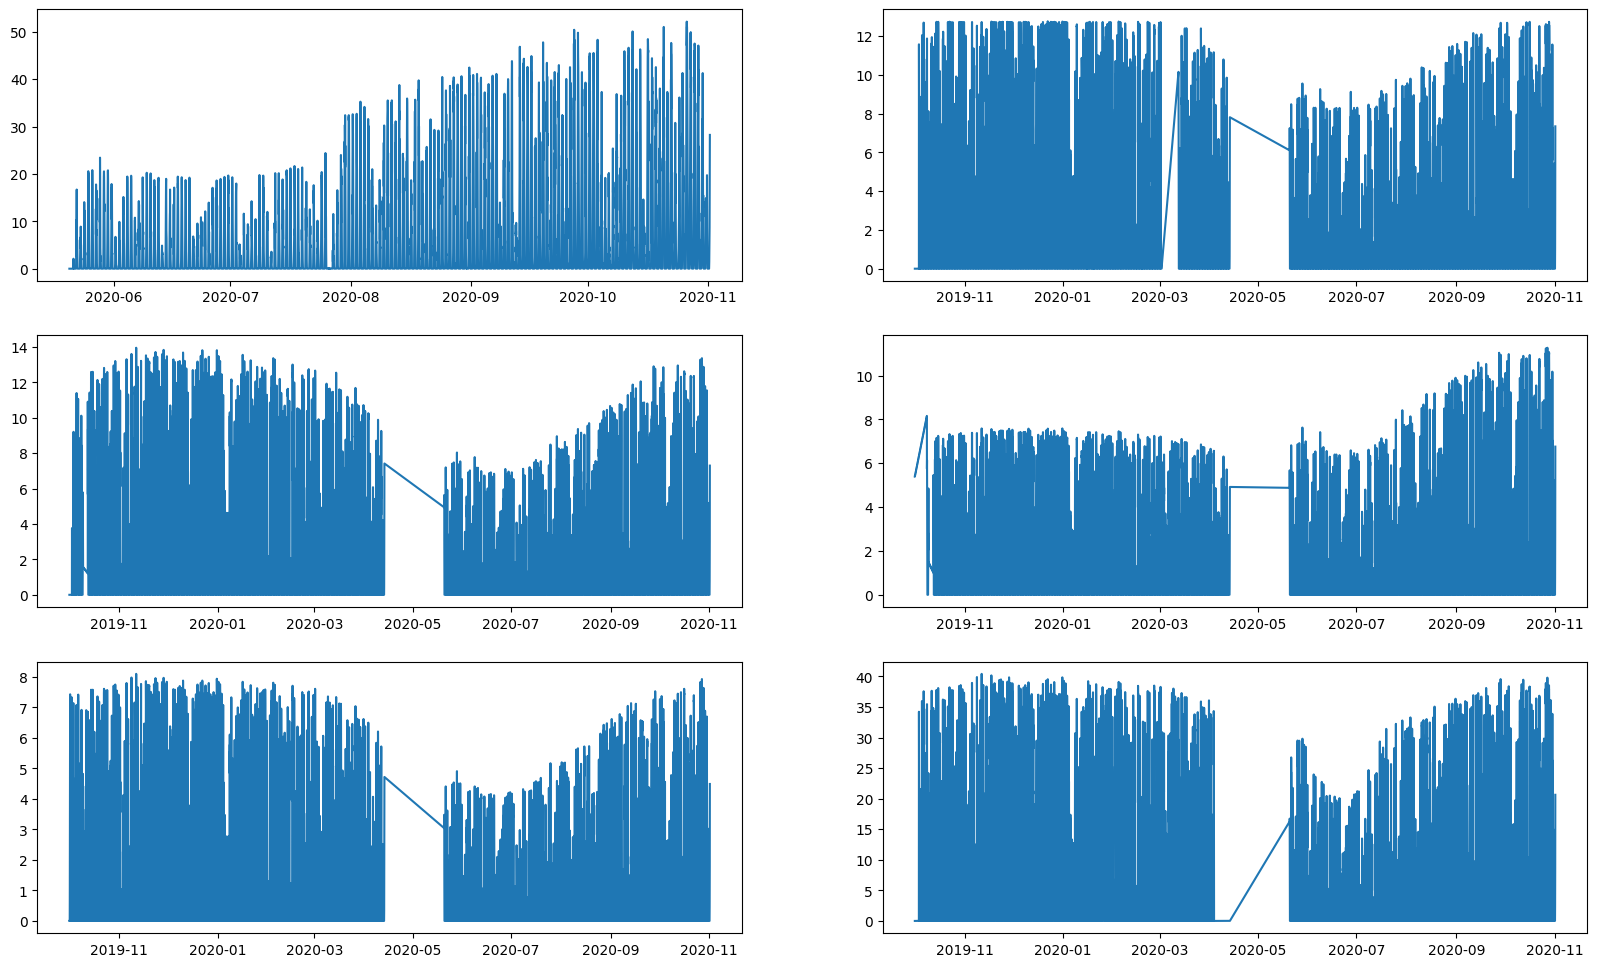

In [231]:
#Plotting Data
fig, ax = plt.subplots(3, 2,figsize=(20, 12))

ax[0, 0].plot(solar0.index,solar0['power_output'])
ax[0, 1].plot(solar1.index,solar1['power_output'])
ax[1, 0].plot(solar2.index,solar2['power_output'])
ax[1, 1].plot(solar3.index,solar3['power_output'])
ax[2, 0].plot(solar4.index,solar4['power_output'])
ax[2, 1].plot(solar5.index,solar5['power_output'])

<ipython-input-218-ed4129397c9c>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(solar.corr(), vmin=-1, vmax=1, annot=True,cmap="Reds")


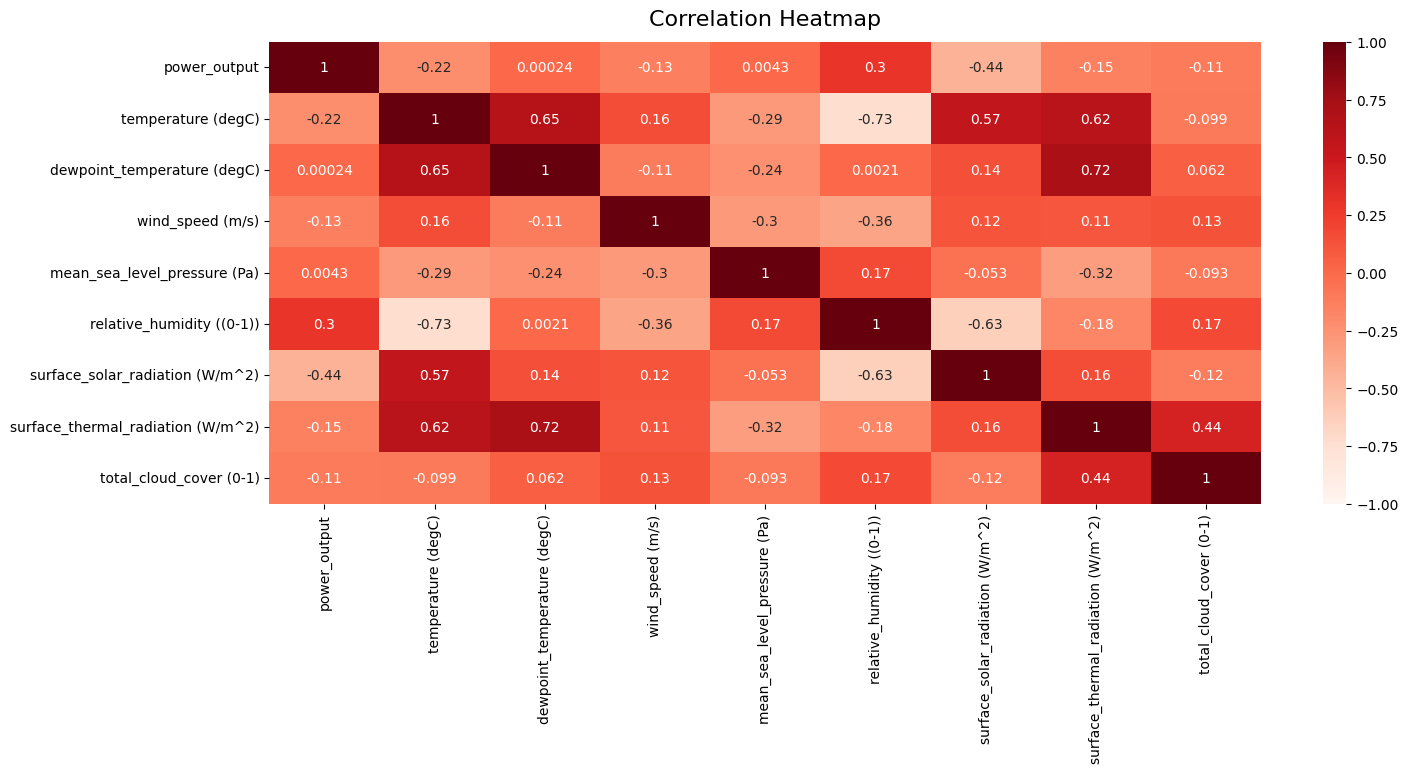

In [234]:
heatmap(solar2)

<ipython-input-237-06c289893438>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["power_output"].loc[mask] = np.nan


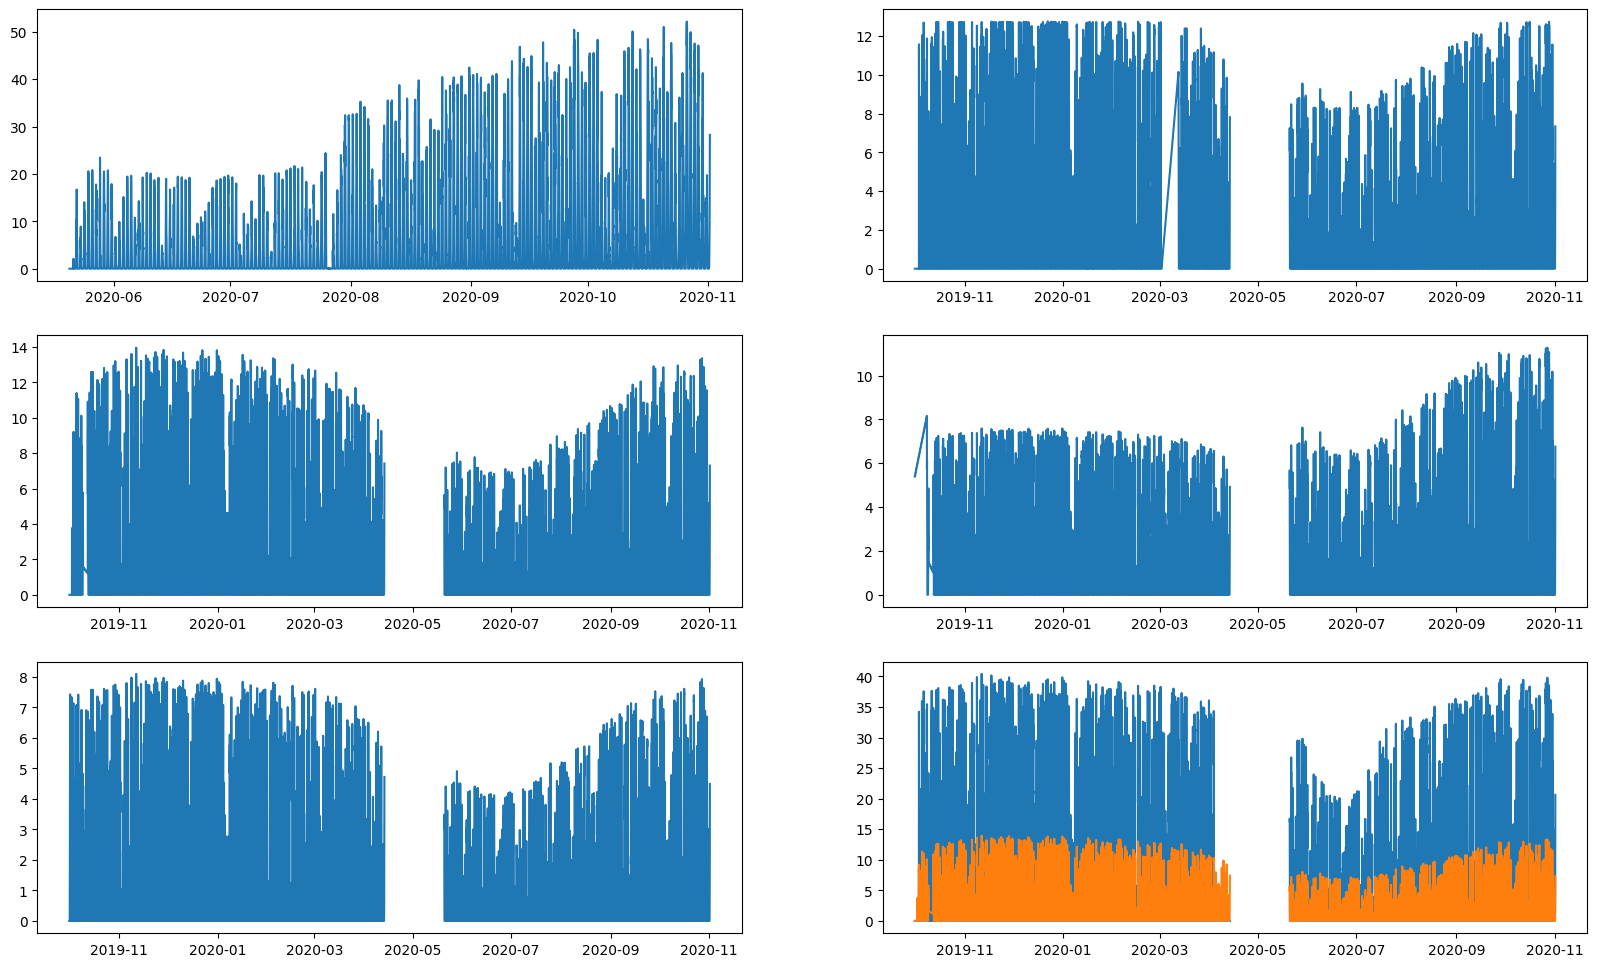

In [237]:
#Interpolation Of Gap
import numpy as np
from sklearn.impute import SimpleImputer
from datetime import datetime

#chatGPT
start = "2020-04-13 12:00:00"
end = "2020-05-20 14:00:00"
start_date = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')  # Replace 'YYYY-MM-DD' with your date
end_date = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

for df in [solar0,solar1,solar2,solar3,solar4,solar5]:
  mask = (df.index <= end_date) & (df.index >= start_date)
  df["power_output"].loc[mask] = np.nan
  #df["power_output"] = df["power_output"].interpolate(method = 'from_derivatives')
#

fig, ax = plt.subplots(3, 2,figsize=(20, 12))

ax[0, 0].plot(solar0.index,solar0['power_output'])
ax[0, 1].plot(solar1.index,solar1['power_output'])
ax[1, 0].plot(solar2.index,solar2['power_output'])
ax[1, 1].plot(solar3.index,solar3['power_output'])
ax[2, 0].plot(solar4.index,solar4['power_output'])
ax[2, 1].plot(solar5.index,solar5['power_output'])
plt.plot(solar2.index,solar2['power_output'])

Text(0, 0.5, 'Air Temp (degrees C)')

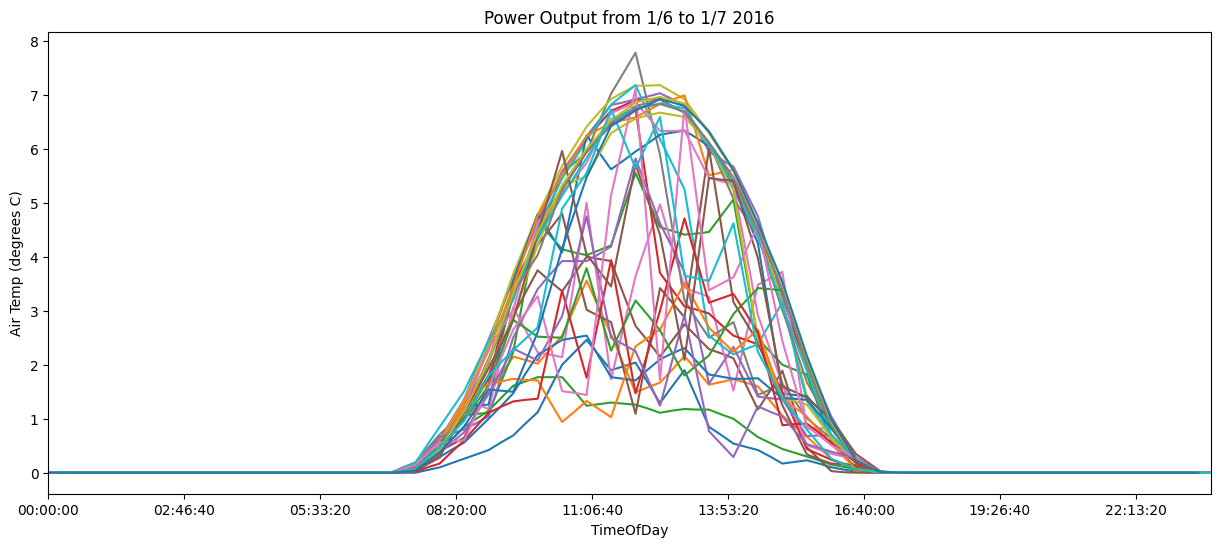

In [264]:
#Weather daily
# Creates three new columns, which specify the date (without time), time of day (without the date)
# and the day of the week as a categorical value.
solar2_daily =  solar2.copy()
solar2_daily =  solar2_daily[pd.Timestamp("2020-06-01 00:00:00"):pd.Timestamp("2020-07-01 23:30:00")]
solar2_daily_power = solar2_daily[["power_output"]]
solar2_daily_power = solar2_daily_power.assign(
    Date=lambda df: df.index.floor("D"),
    TimeOfDay=lambda df: df.index - df.Date,
)

# Just show a few rows with these additional columns.
aggregated = solar2_daily_power.groupby(["Date", "TimeOfDay"]).mean()

pivoted = aggregated.unstack(0)

pivoted.plot.line(figsize=(15, 6), legend = False);
plt.title("Power Output from 1/6 to 1/7 2016")
plt.ylabel("Air Temp (degrees C)")

<ipython-input-261-1a14b2e934d9>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated = solar2_daily_power.groupby(["MonthOfYear", "TimeOfDay"]).mean()


Text(0, 0.5, 'Air Temp (degrees C)')

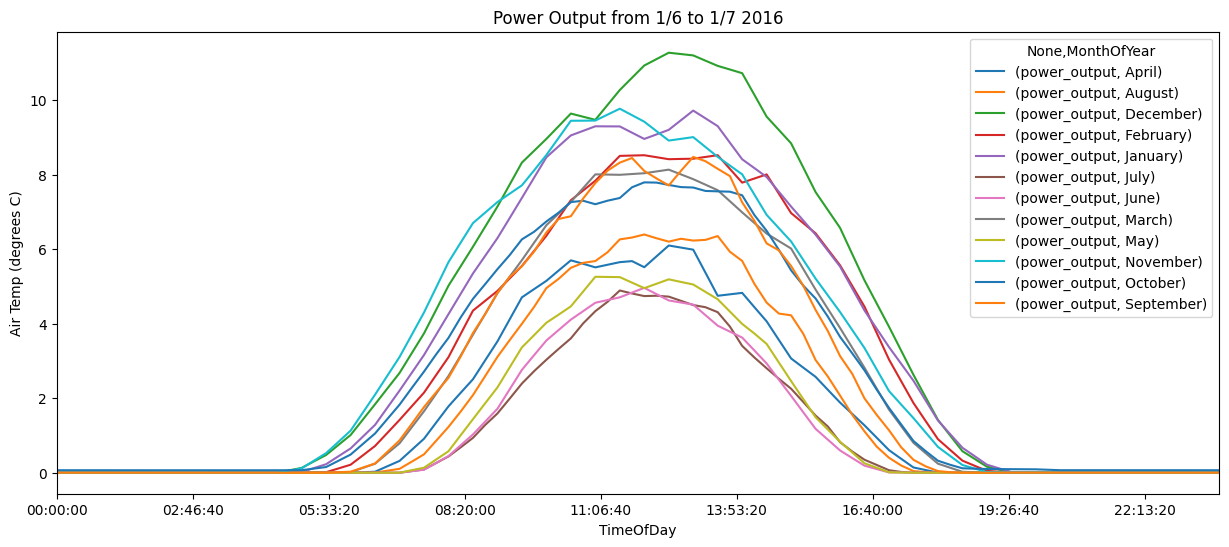

In [261]:
#Weather daily over different months
# Creates three new columns, which specify the date (without time), time of day (without the date)
# and the day of the week as a categorical value.
solar2_monthly =  solar2.copy()
solar2_monthly_power = solar2_daily[["power_output"]]
solar2_monthly_power = solar2_daily_power.assign(
    Date=lambda df: df.index.floor("D"),
    TimeOfDay=lambda df: df.index - df.Date,
    MonthOfYear=lambda df: df.index.month_name().astype("category"),
)

# Just show a few rows with these additional columns.
aggregated = solar2_daily_power.groupby(["MonthOfYear", "TimeOfDay"]).mean()

pivoted = aggregated.unstack(0)

pivoted.plot.line(figsize=(15, 6), legend = True, );
plt.title("Power Output from 1/6 to 1/7 2016")
plt.ylabel("Air Temp (degrees C)")

power_output
Date       TimeOfDay                    
2020-06-01 0 days 00:00:00           0.0
           0 days 00:15:00           0.0
           0 days 00:30:00           0.0
           0 days 00:45:00           0.0
           0 days 01:00:00           0.0
...                                  ...
2020-06-30 0 days 23:00:00           0.0
           0 days 23:15:00           0.0
           0 days 23:30:00           0.0
           0 days 23:45:00           0.0
2020-07-01 0 days 00:00:00           0.0

[2881 rows x 1 columns]

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(aggregated, *['power_output'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(aggregated, *['power_output'], **{})
chart